In [1]:
#!pip install git+https://github.com/openai/glide-text2im
#!pip install sqlite3

In [2]:
import sqlite3

# Connect to SQLite database (creates it if it doesn't exist)
conn = sqlite3.connect('my_database.db')

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Create a table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS users (
        id INTEGER PRIMARY KEY,
        username TEXT,
        email TEXT,
        password TEXT
    )
''')

# Insert data into the table
cursor.execute('''
    INSERT INTO users (username, email, password)
    VALUES (?, ?, ?)
''', ('john_doe', 'john@example.com', 'password123'))

# Commit the transaction
conn.commit()

# Query the table
cursor.execute('SELECT * FROM users')
users = cursor.fetchall()
for user in users:
    print(user)

# Close the cursor and connection
cursor.close()
conn.close()


(1, 'john_doe', 'john@example.com', 'password123')
(2, 'john_doe', 'john@example.com', 'password123')
(3, 'john_doe', 'john@example.com', 'password123')
(4, 'john_doe', 'john@example.com', 'password123')
(5, 'john_doe', 'john@example.com', 'password123')
(6, 'john_doe', 'john@example.com', 'password123')
(7, 'john_doe', 'john@example.com', 'password123')
(8, 'john_doe', 'john@example.com', 'password123')
(9, 'john_doe', 'john@example.com', 'password123')
(10, 'john_doe', 'john@example.com', 'password123')
(11, 'john_doe', 'john@example.com', 'password123')
(12, 'john_doe', 'john@example.com', 'password123')
(13, 'john_doe', 'john@example.com', 'password123')
(14, 'john_doe', 'john@example.com', 'password123')
(15, 'john_doe', 'john@example.com', 'password123')
(16, 'john_doe', 'john@example.com', 'password123')


In [3]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [4]:
has_cuda = False
device = 'cpu'
prompt = ""
diffusion = None
diffusion_up = None
model = None
model_up = None
options = None
options_up = None
samples = None
load_upsample = False
timestep_respacing = '20'

    

In [5]:
# Create base model.
def load_base_model():
    global has_cuda, device, prompt, diffusion, diffusion_up, model, model_up, options, options_up, samples, load_upsample, basemodelloaded
    
    options = model_and_diffusion_defaults()
    options['use_fp16'] = has_cuda
    options['timestep_respacing'] = timestep_respacing # use 100 diffusion steps for fast sampling
    model, diffusion = create_model_and_diffusion(**options)
    model.eval()
    if has_cuda:
        model.convert_to_fp16()
    model.to(device)
    model.load_state_dict(load_checkpoint('base', device))
    print('total base parameters', sum(x.numel() for x in model.parameters()))
    basemodelloaded =True
    # model.del_cache()

In [6]:
# Create upsampler model.
def load_upsampler_model():
    global has_cuda, device, prompt, diffusion, diffusion_up, model, model_up, options, options_up, samples, load_upsample, upsamplerloaded

    options_up = model_and_diffusion_defaults_upsampler()
    options_up['use_fp16'] = has_cuda
    options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
    model_up, diffusion_up = create_model_and_diffusion(**options_up)
    model_up.eval()
    if has_cuda:
        model_up.convert_to_fp16()
    model_up.to(device)
    model_up.load_state_dict(load_checkpoint('upsample', device))
    print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))
    upsamplerloaded = True

In [7]:
from PIL import Image
def show_images(batch: th.Tensor):
    global has_cuda, device, prompt, diffusion, diffusion_up, model, model_up, options, options_up, samples, load_upsample
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    
    x1 = Image.fromarray(reshaped.numpy())
    display(x1)
    return x1      

In [8]:
# Sampling parameters
# prompt = "a very cute cat on a couch"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

In [9]:
##############################
# Sample from the base model #
##############################
def run_basemodel():
    global samples
# Create the text tokens to feed to the model.
    print(prompt)
    
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )

    # Create the classifier-free guidance tokens (empty)
    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
        [], options['text_ctx']
    )

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Create a classifier-free guidance sampling function
    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = th.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = th.cat([half_eps, half_eps], dim=0)
        return th.cat([eps, rest], dim=1)

    # Sample from the base model.
    # model.del_cache()
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    # model.del_cache()

    # Show the output
    return show_images(samples)


In [10]:
##############################
# Upsample the 64x64 samples #
##############################
def run_upsampler():
    global has_cuda, device, prompt, diffusion, diffusion_up, model, model_up, options, options_up, samples, load_upsample
    tokens = model_up.tokenizer.encode(prompt)
    tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
        tokens, options_up['text_ctx']
    )

    # Create the model conditioning dict.
    model_kwargs = dict(
        # Low-res image to upsample.
        low_res=((samples+1)*127.5).round()/127.5 - 1,

        # Text tokens
        tokens=th.tensor(
            [tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Sample from the base model.
    # model_up.del_cache()
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
    up_samples = diffusion_up.ddim_sample_loop(
        model_up,
        up_shape,
        noise=th.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    # model_up.del_cache()

    # Show the output
    return show_images(up_samples)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/assets/css/animate.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/assets/css/templatemo-cyborg-gaming.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/assets/images/a_cute_cat_v2.png HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/assets/css/fontawesome.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/assets/images/profile-header.jpg HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/assets/css/owl.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/vendor/bootstrap/css/bootstrap.min.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/assets/images/football.png HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:17:10] "GET /static/assets/images/download.png HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/

1 False
2 False
User Name: Jeet, Email: jeet.avasare@nuv.ac.in, Password: sjk


POST /register HTTP/1.1" 302 -
127.0.0.1 - - [06/Aug/2024 20:18:46] "GET /login HTTP/1.1" 200 -
127.0.0.1 - - [06/Aug/2024 20:18:46] "GET /static/login_styles.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:18:46] "GET /static/universal_styles.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:18:51] "POST /login HTTP/1.1" 200 -
127.0.0.1 - - [06/Aug/2024 20:18:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Aug/2024 20:18:52] "GET /static/vendor/bootstrap/css/bootstrap.min.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:18:52] "GET /static/assets/css/fontawesome.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:18:52] "GET /static/assets/css/animate.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:18:52] "GET /static/assets/css/templatemo-cyborg-gaming.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:18:52] "GET /static/assets/images/profile-header.jpg HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:18:52] "GET /static/assets/css/owl.css HTTP/1.1" 304 -
127.0.0.1 - - [06/Aug/2024 20:1

total base parameters 385030726
a cute cat


  0%|          | 0/10 [00:00<?, ?it/s]

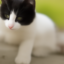

127.0.0.1 - - [06/Aug/2024 20:19:53] "GET /start_render HTTP/1.1" 200 -


In [11]:
from flask import Flask, render_template, request, jsonify, send_file, make_response
from PIL import Image, ImageDraw, ImageFont
import io
from datetime import datetime
import sqlite3
from flask import redirect


app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')



def save_to_database(user_name, email, password):
    conn = sqlite3.connect('userdb.db')
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS users (
            id INTEGER PRIMARY KEY,
            username TEXT,
            email TEXT,
            password TEXT
        )
    ''')
    cursor.execute('INSERT INTO users (username, email, password) VALUES (?, ?, ?)', (user_name, email, password))
    conn.commit()
    conn.close()

@app.route('/register', methods=['GET', 'POST'])
def register():
    if request.method == 'POST':
        
        user_name = request.form['username']
        print("1",user_name==None)
        print("2",user_name=="")
        email = request.form['email']
        password = request.form['password']
        
        print(f"User Name: {user_name}, Email: {email}, Password: {password}")
        
        if user_name != "":
            save_to_database(user_name, email, password)   
        
        return redirect("/login")
    
    return render_template('registration.html')
    

@app.route('/dash')
def dash():
    conn = sqlite3.connect('userdb.db')
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM users')
    users = cursor.fetchall()
    conn.close()
    
    return render_template('dashboard.html', users=users)

@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'GET':
        return render_template('login.html')
    elif request.method == 'POST':
        username = request.form['username']
        password = request.form['password']
        
        conn = sqlite3.connect('userdb.db')
        cursor = conn.cursor()
        cursor.execute('SELECT * FROM users WHERE username = ? AND password = ?', (username, password))
        user = cursor.fetchone()
        conn.close()
        
        if user:
            return jsonify({'message': 'Login successful', 'username': username, 'success': True})
        else:
            return jsonify({'message': 'Invalid username or password', 'success': False})



@app.route('/submit', methods=['POST'])
def submit():
    global prompt, timestep_respacing, load_upsample
    data = request.form.get('input_data')
    prompt = data
    timestep_respacing = str(request.form.get('image_quality', 10))  # Default to 95 if not provided
    load_upsample = (request.form.get('load_upsample', False).lower() ) == 'true'
    # print("Raw Form Data:", request.form)
    return jsonify({'data': data})

@app.route('/start_render')
def start_render():
    global stored_data, timestep_respacing, load_upsample
    
    load_base_model()
    
    if load_upsample == True:
        load_upsampler_model()    

    if load_upsample == True:
        image = run_basemodel()
        image = run_upsampler() 
    else:
        image = run_basemodel() 
    
    img_io = io.BytesIO()
    image.save(img_io, format='PNG', subsampling=0, quality=100)
    img_io.seek(0)

    response = make_response(send_file(img_io, mimetype='image/png', as_attachment=False, download_name="download.png"))
    response.headers['Cache-Control'] = 'no-store, no-cache, must-revalidate, max-age=0'
    return response
    # return send_file(img_io, mimetype='image/png', as_attachment=False, download_name=filename)

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)
